### questions from TJC
 - can we get estimates/error bars from wihtin individuals when it comes to dating admixture
 - can we get individual admixture ages per country (maybe a boxplot).
 - test for selection consider using the same ones from the previous paper and/or iHS.

# Ancestry *S.haematobium* vs. *S. bovis* across Africa (SCAN)

Neal Platt 2021

# Prep envrinoment and data for analyses

use the `sch_hae_scan/envs/jupyterlab_ancestry` conda environment

In [1]:
import os
import allel
import numpy as np
# import loter.locanc.local_ancestry as lc
import pandas as pd
# import vcf
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.pyplot import figure
from tqdm import tqdm
from pathlib import Path
from matplotlib.colors import ListedColormap
import scipy.stats as stats
import statsmodels.stats.multitest as smm
from scipy.signal import medfilt

# from itertools import groupby
# import seaborn as sns
# import pickle
# from collections import Counter
# from IPython.display import Image 
# import dask.dataframe
# from dask.diagnostics import ProgressBar
# import glob
# from dask.distributed import Client
# import pybedtools
# import gffutils
# from scipy.signal import medfilt


In [2]:
proj_dir="/master/nplatt/sch_hae_scan"
results_dir=f"{proj_dir}/results"
os.chdir(results_dir)

## Get sample info

In [3]:
sample_info_df = pd.read_csv(f"{proj_dir}/data/seq_and_sample_docs/all_sh_sb_sample_data.csv")

In [4]:
sample_info_df

,admera_id,barcode_label_ID,library_id,sample_name,sra_accession,presumed_species,country,locale,host,phenotype,project,data_type,lat,lon
0,19047FL-14-02-03,MCF03050E0612,na,sha_angola_cota_57,SRR11907442,s_sp,angola,na,snail,unk,scan_africa,genome,-9.26186,16.13693
1,19047FL-14-02-04,MCF03050E0613,na,sha_angola_cota_58,SRR11907441,s_sp,angola,na,snail,unk,scan_africa,genome,-9.26186,16.13693
2,19047FL-14-02-05,MCF03050E0614,na,sha_angola_cota_59,SRR11907440,s_sp,angola,na,snail,unk,scan_africa,genome,-9.26186,16.13693
3,19047FL-14-02-06,MCF03050E0615,na,sha_angola_icau_60,SRR11907439,s_haematobium,angola,na,human,haematobium,scan_africa,genome,-8.64510,13.79642
4,19047FL-14-02-07,MCF03050E0615,na,sha_angola_icau_61,SRR11907438,s_haematobium,angola,na,human,haematobium,scan_africa,genome,-8.64510,13.79642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,na,na,na,sh_egypt_SRR433862,SRR433862,s_haematobium,egypt,na,na,haematobium,Rey_2019,genome,NaN,NaN
445,na,na,na,sh_gambia_SRR13579872,SRR13579872,s_haematobium,gambia,na,na,haematobium,Rey_2019,genome,NaN,NaN
446,na,na,na,sh_ivorycoast_SRR13579866,SRR13579866,s_haematobium,ivorycoast,na,na,haematobium,Rey_2019,genome,NaN,NaN
447,na,na,na,sh_madagascar_SRR13579871,SRR13579871,s_haematobium,madagascar,na,na,haematobium,Rey_2019,genome,NaN,NaN


## Read in data and get allele counts

In [5]:
#read in the vcf file
filtered_callset=allel.read_vcf('post_phase_filtering/chrs_unrelated.vcf')

In [6]:
#get relevant info
gt      = allel.GenotypeArray(filtered_callset['calldata/GT'])
chroms  = filtered_callset["variants/CHROM"]
samples = filtered_callset["samples"]
poss    = filtered_callset["variants/POS"]
var_ids = filtered_callset["variants/ID"]

uniq_chroms=np.unique(chroms)

In [7]:
#read in pca df since it has species ids and kmeans labels
pca_df=pd.read_csv("{}/pca/pca_df.csv".format(results_dir), sep=",")
pca_df["country"] = pca_df["country"].astype(str)

### Species

In [8]:
#get species idxs
sp_idxs = {}
sp_acs  = {}

for sp in tqdm(["s_bovis", "s_haematobium"]):
    
    #find indecies for each sample from that species
    names = pca_df.loc[pca_df["pca_species"] ==  sp, "sample_name"]
    sp_idxs[sp]=np.in1d(samples, names).nonzero()[0]

    #get allele counts for each species
    sp_acs[sp] = gt.count_alleles(subpop=sp_idxs[sp])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:53<00:00, 26.91s/it]


In [9]:
#add outgroups
s_guineensis   = "guineensis_saotome_ERR119612"
s_intercalatum = "intercalatum_drcongo_ERR119613"
s_margrebowiei = "margrebowiei_zambia_ERR310940"
s_matthei      = "matthei_zambia_ERR103051"

outgroups=[s_guineensis, s_intercalatum, s_margrebowiei, s_matthei]


In [10]:
for sp in tqdm(outgroups):
    sp_idxs[sp] = [list(samples).index(sp)]
    sp_acs[sp] = gt.count_alleles(subpop=sp_idxs[sp])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.31s/it]


### Kmeans group

In [11]:
#get species idxs
k_pop_idxs = {}
k_pop_acs  = {}

for k in tqdm(pca_df["kmeans_label"].unique()):
    
    #find indecies for each sample per k population
    ks = pca_df.loc[pca_df["kmeans_label"] ==  k, "sample_name"]
    k_pop_idxs[k]=np.in1d(samples, ks).nonzero()[0]
    
    #get allele counts for k group
    k_pop_acs[k] = gt.count_alleles(subpop=k_pop_idxs[k])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [01:01<00:00,  8.78s/it]


In [12]:
major_acs={"sh_nw":  k_pop_acs["sh_nw"],
           "sh_se": k_pop_acs["sh_se"],
           "sb":    k_pop_acs["sb"] ,
           "sh":    sp_acs["s_haematobium"],
           "s_guineensis":   sp_acs["guineensis_saotome_ERR119612"],
           "s_intercalatum": sp_acs["intercalatum_drcongo_ERR119613"],
           "s_margrebowiei": sp_acs["margrebowiei_zambia_ERR310940"],
           "s_matthei":      sp_acs["matthei_zambia_ERR103051"]  }

# Pi and Tajima's D

In [13]:
Path("{}/summary_stats".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/summary_stats".format(results_dir))

In [14]:
window_kb_size = 10
window_bp_size = 500

In [15]:
stat_dfs=defaultdict(lambda: pd.DataFrame(columns=["pi", "tajimas_d", "start", "stop", "n_bases", "n_snps", "chrom"]))

major_chroms=uniq_chroms[0:8]
pops=["sh", "sh_nw", "sh_se", "sb"]

for pop in pops:
    for chrom in tqdm(major_chroms):
        chrom_pos = poss[chroms == chrom]
        chrom_ac =  major_acs[pop][chroms == chrom]
        
        try:
            pi, windows, nbases, counts = allel.windowed_diversity(chrom_pos, chrom_ac, window_kb_size*1_000)
            td, windows, counts =  allel.windowed_tajima_d(chrom_pos, chrom_ac, size=window_kb_size*1_000)

            #add info to a df
            chr_df=pd.DataFrame([pi, td, windows[:,0], windows[:,1], nbases, counts]).T
            chr_df.columns=["pi", "tajimas_d", "start", "stop", "n_bases", "n_snps"]
            chr_df["chrom"]=chrom

            stat_dfs[pop]=pd.concat([stat_dfs[pop], chr_df])

        except:
            print(f"An exception occurred: {pop}:{chrom}")
            break

        #reset index
        stat_dfs[pop]=stat_dfs[pop].reset_index(drop=True)

        #save df to a csv
        stat_dfs[pop].to_csv(f"summary_stats_{window_kb_size}kb_windows_{pop}.csv", index=False, sep=",")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:35<00:00,  4.43s/it]


In [16]:
df = stat_dfs["sh_se"][["chrom", "start", "stop", "n_snps"]].copy()

df["se_pi"] = stat_dfs["sh_se"]["pi"]
df["sb_pi"] = stat_dfs["sb"]["pi"]
df["nw_pi"] = stat_dfs["sh_nw"]["pi"]
df["sh_pi"] = stat_dfs["sh"]["pi"]

df["se_td"] = stat_dfs["sh_se"]["tajimas_d"]
df["sb_td"] = stat_dfs["sb"]["tajimas_d"]
df["nw_td"] = stat_dfs["sh_nw"]["tajimas_d"]
df["sh_td"] = stat_dfs["sh"]["tajimas_d"]

cols_to_modify = ['se_pi', 'sb_pi', 'nw_pi', 'sh_pi', "se_td", "sb_td", "nw_td", "sh_td"]

# Use .loc to set values to NaN based on the condition
df.loc[df['n_snps'] == 0, cols_to_modify] = np.nan


df.to_csv("summary_stats.csv", sep=",", header=True, index=False, na_rep=np.nan)
df

,chrom,start,stop,n_snps,se_pi,sb_pi,nw_pi,sh_pi,se_td,sb_td,nw_td,sh_td
0,NC_067195.1,14416.0,24415.0,147.0,0.000977,0.001125,0.001046,0.001077,0.205585,-0.245927,-1.066640,-1.167396
1,NC_067195.1,24416.0,34415.0,177.0,0.000381,0.001331,0.000743,0.000608,-1.697061,-0.923843,-1.575858,-1.864238
2,NC_067195.1,34416.0,44415.0,80.0,0.000369,0.001181,0.000403,0.000399,-0.874169,0.059105,-1.475178,-1.486924
3,NC_067195.1,44416.0,54415.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NC_067195.1,54416.0,64415.0,11.0,0.000060,0.000227,0.000043,0.000051,0.135164,0.624879,-1.000305,-0.911767
...,...,...,...,...,...,...,...,...,...,...,...,...
39187,NC_067202.1,19430276.0,19440275.0,516.0,0.002791,0.003523,0.002784,0.002834,0.316147,-1.089071,-0.154628,-0.522089
39188,NC_067202.1,19440276.0,19450275.0,118.0,0.000644,0.000992,0.000653,0.000661,-0.675211,-0.794586,-0.585316,-0.924480
39189,NC_067202.1,19450276.0,19460275.0,665.0,0.006323,0.007038,0.007115,0.006875,1.183424,-0.199034,0.071655,-0.156687
39190,NC_067202.1,19460276.0,19470275.0,1403.0,0.011685,0.014330,0.011202,0.011634,0.466402,-0.307397,-0.456642,-0.588923


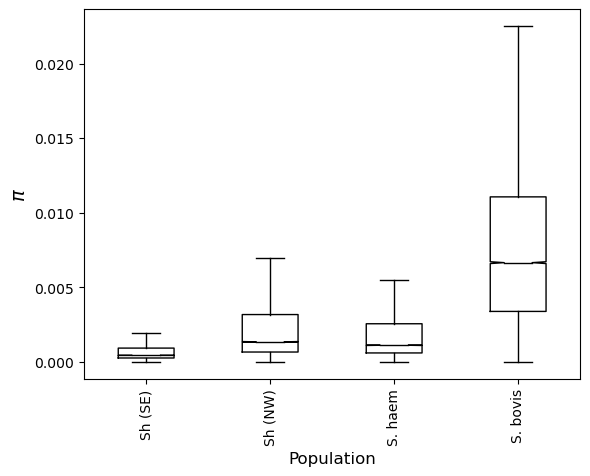

pop	mean_pi	stdev
se	0.0012940643758073368	0.0023215689721204314
nw	0.002643543012855745	0.0032447476123985924
sh	0.0022918123721368407	0.0029668373131863817
sb	0.007534431399622306	0.005068374927592974


In [17]:
plt.boxplot([ df["se_pi"].dropna(),
              df["nw_pi"].dropna(),
              df["sh_pi"].dropna(),
              df["sb_pi"].dropna()    ],
            
             showfliers=False, 
             notch=True,
             labels=["Sh (SE)", "Sh (NW)", "S. haem", "S. bovis" ],

             medianprops=dict(color="black", lw=1))

plt.xticks(rotation=90)
plt.xlabel("Population", fontsize=12)
plt.ylabel("$\pi$", fontsize=14)
plt.savefig("pi_boxplot_{}kb_windows.svg".format(window_kb_size))
plt.savefig("pi_boxplot_{}kb_windows.png".format(window_kb_size), dpi=300)
plt.show()


with open("pi_summary.tsv", 'w') as outfile:
    outfile.write("pop\tmean_pi\tstdev\n")
    for pop in ["se", "nw", "sh", "sb"]:
        pi_pop=f"{pop}_pi"

        mean_pi = df[pi_pop].dropna().mean()
        std = df[pi_pop].dropna().std()
        outfile.write(f"{pop}\t{mean_pi}\t{std}\n")
        
!cat pi_summary.tsv

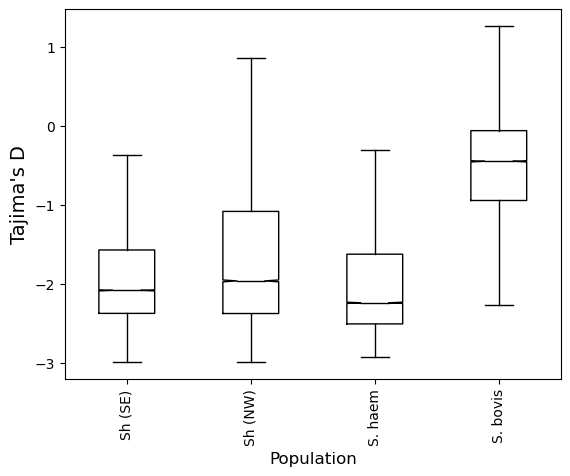

pop	mean_td	stdev
se	-1.7561291399445977	1.027708463487134
nw	-1.576557518745043	1.1015406159008847
sh	-1.9043131394684287	0.9127642309146013
sb	-0.4974813779780144	0.6957685645806682


In [132]:
plt.boxplot([ df["se_td"].dropna(),
              df["nw_td"].dropna(),
              df["sh_td"].dropna(),
              df["sb_td"].dropna()    ],
            
             showfliers=False, 
             notch=True,
             labels=["Sh (SE)", "Sh (NW)", "S. haem", "S. bovis" ],

             medianprops=dict(color="black", lw=1))

plt.xticks(rotation=90)
plt.xlabel("Population", fontsize=12)
plt.ylabel("Tajima's D", fontsize=14)
plt.savefig("td_boxplot_{}kb_windows.svg".format(window_kb_size))
plt.savefig("td_boxplot_{}kb_windows.png".format(window_kb_size), dpi=300)
plt.show()

with open("td_summary.tsv", 'w') as outfile:
    outfile.write("pop\tmean_td\tstdev\n")
    for pop in ["se", "nw", "sh", "sb"]:
        td_pop=f"{pop}_td"

        mean = df[td_pop].dropna().mean()
        std = df[td_pop].dropna().std()
        outfile.write(f"{pop}\t{mean}\t{std}\n")
        
!cat td_summary.tsv

# Pi across the genome

In [133]:
df=pd.read_csv("summary_stats.csv", sep=",", header=0)


In [134]:
uniq_chroms= ["NC_067196.1", "NC_067197.1", "NC_067198.1", "NC_067199.1", "NC_067200.1", "NC_067201.1", "NC_067202.1"]


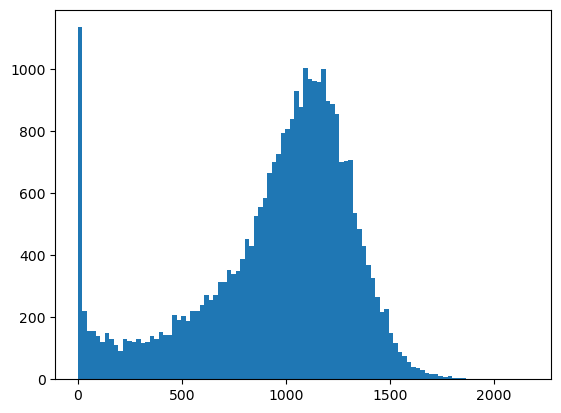

In [135]:
plt.hist(df["n_snps"], bins=100)
plt.show()

In [136]:
pos_df = pd.read_csv(f"{proj_dir}/results/fig_plotting_info/plotting_info.csv", sep=",") #generated in prep_figs_info.ipynb

offsets=dict(zip(pos_df["contig"], pos_df["x_start"].astype(int)))
colors=dict(zip(pos_df["contig"], pos_df["color"].astype(str)))

x=[]
c=[]

for index, row in df.iterrows():
    chrom = row["chrom"]
    
    offset=offsets[chrom]
    color = colors[chrom]
    
    x.append(row["start"] + offset)
    c.append(color)
    
df["genomic_position"] = x
df["color"] = c

df.to_csv("summary_stats.csv", header=True, sep=",", index=False)
df = df.sort_values("genomic_position").reset_index(drop=True)
df

,chrom,start,stop,n_snps,se_pi,sb_pi,nw_pi,sh_pi,se_td,sb_td,nw_td,sh_td,genomic_position,color
0,NC_067196.1,124225.0,134224.0,39.0,0.000054,0.000431,0.000179,0.000138,-1.337341,0.101853,-0.181920,-0.806126,124225.0,#078d70
1,NC_067196.1,134225.0,144224.0,10.0,0.000014,0.000050,0.000034,0.000026,NaN,-1.432528,-0.589087,-1.006630,134225.0,#078d70
2,NC_067196.1,144225.0,154224.0,109.0,0.000969,0.001077,0.000962,0.001050,0.048596,-0.613809,-0.610139,-0.484807,144225.0,#078d70
3,NC_067196.1,154225.0,164224.0,105.0,0.000697,0.000958,0.001078,0.001113,-0.887484,-0.734379,-0.181947,-0.496516,154225.0,#078d70
4,NC_067196.1,164225.0,174224.0,3.0,0.000007,0.000014,0.000041,0.000029,NaN,NaN,NaN,NaN,164225.0,#078d70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30273,NC_067202.1,19430276.0,19440275.0,516.0,0.002791,0.003523,0.002784,0.002834,0.316147,-1.089071,-0.154628,-0.522089,317862744.0,#078d70
30274,NC_067202.1,19440276.0,19450275.0,118.0,0.000644,0.000992,0.000653,0.000661,-0.675211,-0.794586,-0.585316,-0.924480,317872744.0,#078d70
30275,NC_067202.1,19450276.0,19460275.0,665.0,0.006323,0.007038,0.007115,0.006875,1.183424,-0.199034,0.071655,-0.156687,317882744.0,#078d70
30276,NC_067202.1,19460276.0,19470275.0,1403.0,0.011685,0.014330,0.011202,0.011634,0.466402,-0.307397,-0.456642,-0.588923,317892744.0,#078d70


In [137]:
ratio = np.log10(df["nw_pi"].astype(float)/df["se_pi"].astype(float))
df["pi_ratio_nw_se"]=ratio

ratio = np.log10(df["nw_pi"].astype(float)/df["sb_pi"].astype(float))
df["pi_ratio_nw_sb"]=ratio

ratio = np.log10(df["sb_pi"].astype(float)/df["se_pi"].astype(float))
df["pi_ratio_sb_se"]=ratio


df.to_csv("summary_stats.csv", header=True, sep=",", index=False)
df
#plt.scatter(x=pi_df["genomic_position"], y=pi_df["pi_ratio_nw_se"])


/master/nplatt/anaconda3/envs/ancestry/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/master/nplatt/anaconda3/envs/ancestry/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/master/nplatt/anaconda3/envs/ancestry/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,chrom,start,stop,n_snps,se_pi,sb_pi,nw_pi,sh_pi,se_td,sb_td,nw_td,sh_td,genomic_position,color,pi_ratio_nw_se,pi_ratio_nw_sb,pi_ratio_sb_se
0,NC_067196.1,124225.0,134224.0,39.0,0.000054,0.000431,0.000179,0.000138,-1.337341,0.101853,-0.181920,-0.806126,124225.0,#078d70,0.518677,-0.381054,0.899731
1,NC_067196.1,134225.0,144224.0,10.0,0.000014,0.000050,0.000034,0.000026,NaN,-1.432528,-0.589087,-1.006630,134225.0,#078d70,0.371971,-0.167846,0.539817
2,NC_067196.1,144225.0,154224.0,109.0,0.000969,0.001077,0.000962,0.001050,0.048596,-0.613809,-0.610139,-0.484807,144225.0,#078d70,-0.003400,-0.049144,0.045743
3,NC_067196.1,154225.0,164224.0,105.0,0.000697,0.000958,0.001078,0.001113,-0.887484,-0.734379,-0.181947,-0.496516,154225.0,#078d70,0.189110,0.051180,0.137930
4,NC_067196.1,164225.0,174224.0,3.0,0.000007,0.000014,0.000041,0.000029,NaN,NaN,NaN,NaN,164225.0,#078d70,0.788711,0.475456,0.313256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30273,NC_067202.1,19430276.0,19440275.0,516.0,0.002791,0.003523,0.002784,0.002834,0.316147,-1.089071,-0.154628,-0.522089,317862744.0,#078d70,-0.001044,-0.102255,0.101210
30274,NC_067202.1,19440276.0,19450275.0,118.0,0.000644,0.000992,0.000653,0.000661,-0.675211,-0.794586,-0.585316,-0.924480,317872744.0,#078d70,0.006146,-0.181875,0.188022
30275,NC_067202.1,19450276.0,19460275.0,665.0,0.006323,0.007038,0.007115,0.006875,1.183424,-0.199034,0.071655,-0.156687,317882744.0,#078d70,0.051290,0.004744,0.046546
30276,NC_067202.1,19460276.0,19470275.0,1403.0,0.011685,0.014330,0.011202,0.011634,0.466402,-0.307397,-0.456642,-0.588923,317892744.0,#078d70,-0.018326,-0.106942,0.088616


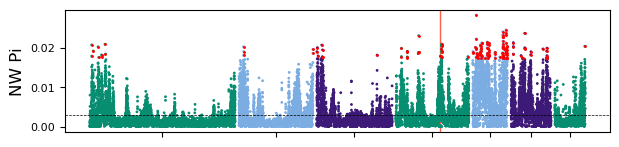

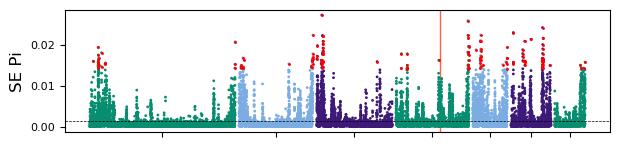

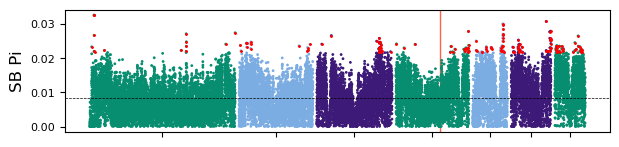

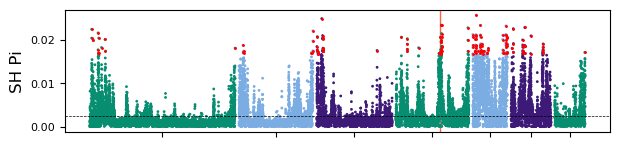

In [209]:
# Create the Manhattan plot figure and axis

num_snvs_in_window_filter=0

for pop in ["nw", "se", "sb", "sh"]:
    cm = 1/2.54
    fig, ax = plt.subplots(figsize=(16*cm, 4*cm), facecolor="white")

    tmp_df = df.loc[df[f"{pop}_pi"] > num_snvs_in_window_filter]

    # Iterate through the groups of chromosomes and plot each group with a different color

    for i, (chrom, group) in enumerate(tmp_df.loc[tmp_df["chrom"] != "NC_067195.1"].groupby("chrom")):
        ax.scatter(group["genomic_position"], group[f"{pop}_pi"], s=1, alpha=1, color=group["color"], label=f'{chrom}', zorder=2)

        
    # get top and bottom 1%
    rank = (tmp_df[f"{pop}_pi"].rank()-1) / len(tmp_df[f"{pop}_pi"])
    rank_df = tmp_df.loc[(rank > 0.995)].copy()
    for i, (chrom, group) in enumerate(rank_df.loc[tmp_df["chrom"] != "NC_067195.1"].groupby("chrom")):
        ax.scatter(group["genomic_position"], group[f"{pop}_pi"], s=1.1, alpha=1, color="red", label=f'{chrom}', zorder=2)



    # Set the x-axis and y-axis labels
    label=f"{pop.upper()} Pi"
    ax.set_ylabel(f"{label}", fontsize=12)

    ax.tick_params(axis='y', labelsize=8)


    x_ticks  = list(pos_df["mid_tick"].astype(int)[0:7])
    x_labels = list(pos_df["contig"].astype(str)[0:7])
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([])


    pi_rat=tmp_df[f"{pop}_pi"][np.isfinite(tmp_df[f"{pop}_pi"])]
    pi_lim = max([abs(pi_rat.min()), abs(pi_rat.max())])

    #ax.set_ylim(pi_rat.min() -0.5, pi_rat.max() + 0.5)


    #plot invadolysin line
    invad_loc_x = offsets["NC_067199.1"] + ((28_467_137+28_495_140)/2)
    invad_loc_x
    ax.axvline(x=invad_loc_x, color='tomato', linestyle="solid", linewidth=1, zorder=1)

    #ax.axhline(y=0, color='grey', linestyle="--", linewidth=0.2, zorder=1)
    comp_mean=tmp_df.loc[np.isfinite(tmp_df[f"{pop}_pi"]), f"{pop}_pi"].mean()
    ax.axhline(y=comp_mean, color='black', linestyle="--", linewidth=0.5, zorder=4)

    # Adjust the layout to fit the plot in the figure
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Save the plot as an SVG file
    fig.savefig(f'{pop}_pi.svg', format='svg')

    # Save the plot as a 300 dpi PNG file
    fig.savefig(f'{pop}_pi.png', dpi=300, format='png')


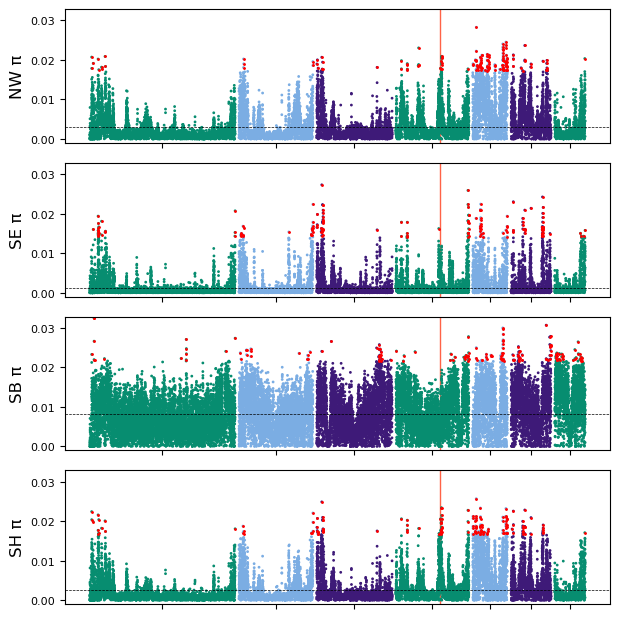

In [278]:
num_snvs_in_window_filter=1

max_pi = df[["sh_pi", "sb_pi", "se_pi", "nw_pi"]].max(axis=1).max()

# Create a single figure with 4 subplots in 1 column and 4 rows
cm = 1/2.54
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(16*cm, 16*cm), facecolor="white")

for pop, ax in zip(["nw", "se", "sb", "sh"], axes):
    
    tmp_df = df.loc[df[f"n_snps"] > num_snvs_in_window_filter]

    # Iterate through the groups of chromosomes and plot each group with a different color

    for i, (chrom, group) in enumerate(tmp_df.loc[tmp_df["chrom"] != "NC_067195.1"].groupby("chrom")):
        ax.scatter(group["genomic_position"], group[f"{pop}_pi"], s=1, alpha=1, color=group["color"], label=f'{chrom}', zorder=2)

        
    # get top and bottom 1%
    rank = (tmp_df[f"{pop}_pi"].rank()-1) / len(tmp_df[f"{pop}_pi"])
    rank_df = tmp_df.loc[(rank > 0.995)].copy()
    for i, (chrom, group) in enumerate(rank_df.loc[tmp_df["chrom"] != "NC_067195.1"].groupby("chrom")):
        ax.scatter(group["genomic_position"], group[f"{pop}_pi"], s=1.1, alpha=1, color="red", label=f'{chrom}', zorder=2)



    # Set the x-axis and y-axis labels
    label=f"{pop.upper()} \u03C0"
    ax.set_ylabel(f"{label}", fontsize=12)
    ax.set_ylim(-0.001, max_pi*1.01)
    ax.tick_params(axis='y', labelsize=8)


    x_ticks  = list(pos_df["mid_tick"].astype(int)[0:7])
    x_labels = list(pos_df["contig"].astype(str)[0:7])
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([])


    pi_rat=tmp_df[f"{pop}_pi"][np.isfinite(tmp_df[f"{pop}_pi"])]
    pi_lim = max([abs(pi_rat.min()), abs(pi_rat.max())])

    #ax.set_ylim(pi_rat.min() -0.5, pi_rat.max() + 0.5)


    #plot invadolysin line
    invad_loc_x = offsets["NC_067199.1"] + ((28_467_137+28_495_140)/2)
    invad_loc_x
    ax.axvline(x=invad_loc_x, color='tomato', linestyle="solid", linewidth=1, zorder=1)

    #ax.axhline(y=0, color='grey', linestyle="--", linewidth=0.2, zorder=1)
    comp_mean=tmp_df.loc[np.isfinite(tmp_df[f"{pop}_pi"]), f"{pop}_pi"].mean()
    ax.axhline(y=comp_mean, color='black', linestyle="--", linewidth=0.5, zorder=4)

    # Adjust the layout to fit the plot in the figure
    plt.tight_layout()

# Show the entire figure with all subplots
plt.tight_layout()
plt.show()

# Save the entire figure as an SVG and PNG file
fig.savefig('all_pops_pi.svg', format='svg')
fig.savefig('all_pops_pi.png', dpi=300, format='png')


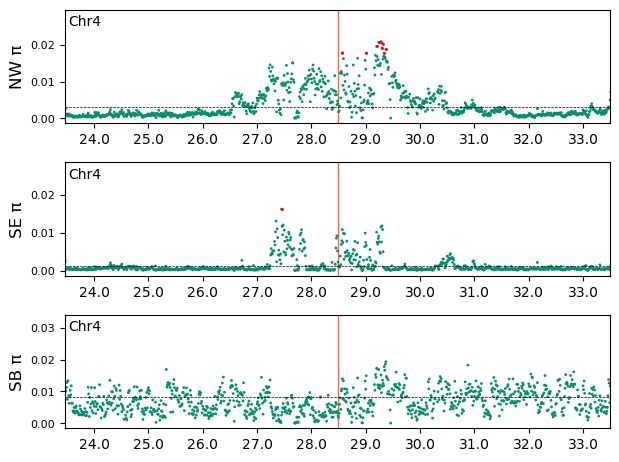

In [274]:
num_snvs_in_window_filter=1

pops=["nw", "se", "sb"]

# Create a single figure with 4 subplots in 1 column and 4 rows
cm = 1/2.54
fig, axes = plt.subplots(nrows=len(pops), ncols=1, figsize=(16*cm, len(pops)*4*cm), facecolor="white")

for pop, ax in zip(pops, axes):
    
    tmp_df = df.loc[df[f"n_snps"] > num_snvs_in_window_filter]

    # Iterate through the groups of chromosomes and plot each group with a different color

    for i, (chrom, group) in enumerate(tmp_df.loc[tmp_df["chrom"] != "NC_067195.1"].groupby("chrom")):
        ax.scatter(group["genomic_position"], group[f"{pop}_pi"], s=1, alpha=1, color=group["color"], label=f'{chrom}', zorder=2)

        
    # get top and bottom 1%
    rank = (tmp_df[f"{pop}_pi"].rank()-1) / len(tmp_df[f"{pop}_pi"])
    rank_df = tmp_df.loc[(rank > 0.995)].copy()
    for i, (chrom, group) in enumerate(rank_df.loc[tmp_df["chrom"] != "NC_067195.1"].groupby("chrom")):
        ax.scatter(group["genomic_position"], group[f"{pop}_pi"], s=1.1, alpha=1, color="red", label=f'{chrom}', zorder=2)



    # Set the x-axis and y-axis labels
    label=f"{pop.upper()} \u03C0"
    ax.set_ylabel(f"{label}", fontsize=12)

    ax.tick_params(axis='y', labelsize=8)


    x_ticks = list(range(0, chr4_len+1, 1_000_000))
    x_tick_pos = [x + offsets['NC_067199.1'] for x in x_ticks]
    x_tick_label = [str(x/1000000) for x in x_ticks]
    x_tick_label
    ax.set_xticks(x_tick_pos)
    ax.set_xticklabels(x_tick_label)


    #ax.set_ylim(pi_rat.min() -0.5, pi_rat.max() + 0.5)
    x_min=offsets["NC_067199.1"] + (28_467_137) - 5000000
    x_max=offsets["NC_067199.1"] + (28_495_140) + 5000000
    ax.set_xlim([x_min, x_max])
    #ax.set_ylim([-0.001, 0.0275])

    # Get current x and y limits
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()

    # Position text in the upper right corner (you might need to adjust the offsets for better positioning)
    ax.text(x_lim[0]+50_000, y_lim[1]*0.95, 'Chr4', ha='left', va='top')


    #plot invadolysin line
    invad_loc_x = offsets["NC_067199.1"] + ((28_467_137+28_495_140)/2)
    invad_loc_x
    ax.axvline(x=invad_loc_x, color='tomato', linestyle="solid", linewidth=1, zorder=1)

    #ax.axhline(y=0, color='grey', linestyle="--", linewidth=0.2, zorder=1)
    comp_mean=tmp_df.loc[np.isfinite(tmp_df[f"{pop}_pi"]), f"{pop}_pi"].mean()
    ax.axhline(y=comp_mean, color='black', linestyle="--", linewidth=0.5, zorder=4)


# Show the entire figure with all subplots
plt.tight_layout()
plt.show()

# Save the entire figure as an SVG and PNG file
fig.savefig('zoom_all_pops_pi.svg', format='svg')
fig.savefig('zoom_all_pops_pi.png', dpi=300, format='png')


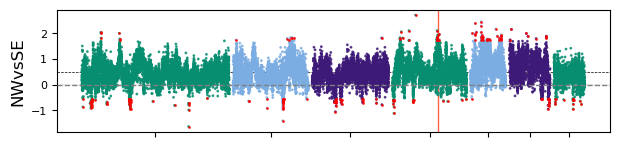

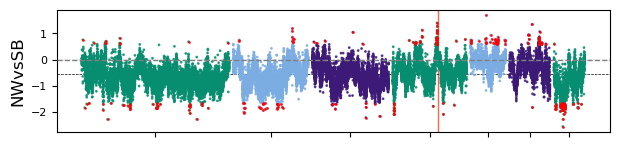

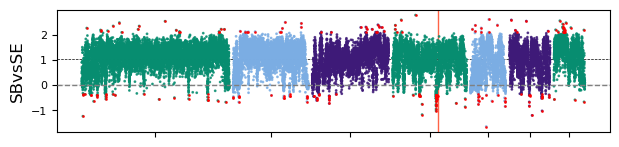

In [190]:
# Create the Manhattan plot figure and axis
num_snvs_in_window_filter=5

for comp in ["nw_se", "nw_sb", "sb_se"]:
    cm = 1/2.54
    fig, ax = plt.subplots(figsize=(16*cm, 4*cm), facecolor="white")

    tmp_df = df.loc[df["n_snps"] > num_snvs_in_window_filter]

    # Iterate through the groups of chromosomes and plot each group with a different color

    for i, (chrom, group) in enumerate(tmp_df.loc[tmp_df["chrom"] != "NC_067195.1"].groupby("chrom")):
        ax.scatter(group["genomic_position"], group[f"pi_ratio_{comp}"], s=1, alpha=0.8, color=group["color"], label=f'{chrom}', zorder=2)

        
    # get top and bottom 1%
    rank = (tmp_df[f'pi_ratio_{comp}'].rank()-1) / len(tmp_df[f'pi_ratio_{comp}'])
    rank_df = tmp_df.loc[(rank > 0.995) | (rank < 0.005)].copy()
    for i, (chrom, group) in enumerate(rank_df.loc[tmp_df["chrom"] != "NC_067195.1"].groupby("chrom")):
        ax.scatter(group["genomic_position"], group[f"pi_ratio_{comp}"], s=1, alpha=0.8, color="red", label=f'{chrom}', zorder=2)



    # Set the x-axis and y-axis labels
    label=comp.upper().replace("_", "vs")
    ax.set_ylabel(f"{label}", fontsize=12)

    ax.tick_params(axis='y', labelsize=8)


    x_ticks  = list(pos_df["mid_tick"].astype(int)[0:7])
    x_labels = list(pos_df["contig"].astype(str)[0:7])
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([])


    pi_rat=tmp_df[f"pi_ratio_{comp}"][np.isfinite(tmp_df[f"pi_ratio_{comp}"])]
    pi_lim = max([abs(pi_rat.min()), abs(pi_rat.max())])

    #ax.set_ylim(pi_rat.min() -0.5, pi_rat.max() + 0.5)


    #plot invadolysin line
    invad_loc_x = offsets["NC_067199.1"] + ((28_467_137+28_495_140)/2)
    invad_loc_x
    ax.axvline(x=invad_loc_x, color='tomato', linestyle="solid", linewidth=1, zorder=1)

    ax.axhline(y=0, color='grey', linestyle="--", linewidth=1, zorder=4)

    ax.axhline(y=0, color='grey', linestyle="--", linewidth=0.2, zorder=1)
    comp_mean=tmp_df.loc[np.isfinite(tmp_df[f"pi_ratio_{comp}"]), f"pi_ratio_{comp}"].mean()
    ax.axhline(y=comp_mean, color='black', linestyle="--", linewidth=0.5, zorder=1)

    # Adjust the layout to fit the plot in the figure
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Save the plot as an SVG file
    fig.savefig(f'{label}_pi_ratio.svg', format='svg')

    # Save the plot as a 300 dpi PNG file
    fig.savefig(f'{label}_pi_ratio.png', dpi=300, format='png')
